In [12]:
import os
import sys
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# %matplotlib inline
warnings.filterwarnings('ignore')

In [13]:
sys.path.append(os.path.join('..', 'src'))

In [14]:
import importlib
import utils, params
importlib.reload(utils)
from utils import capture_data

importlib.reload(params)
from params import ProjectParameters

# define functions

In [15]:
def visualize_correlations(file_folder, df, file, annotation=True):
    # constroi matriz de correlação de Pearson com valores arredondados (2 decimais)
    corrmatrix = df.corr().apply(lambda x: round(x, 2))

    #constroi heatmap
    f, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(corrmatrix, cmap='RdBu', center=0, square=True, annot=annotation, annot_kws={'fontsize':9}, cbar_kws={'shrink':.8 }, 
                yticklabels=1, ax=ax, linewidths=0.1) #
    plt.title('Variable correlations', pad=20, size=15)
    plt.savefig(os.path.join(file_folder, file), bbox_inches = "tight")
    
def calculate_vif(df, threshold=5):
    collinear_vars = []
    variables = list(range(df.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(df.iloc[:, variables].values, ix)
               for ix in range(df.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > threshold:
            var = df.iloc[:, variables].columns[maxloc]
            del variables[maxloc]
            collinear_vars.append(var)
            dropped = True
            
    return collinear_vars

def save_csv(sufix, label=False):
    file = sufix + '.csv'
    if label==False: 
        df = eval(sufix)
    else: 
        df = pd.DataFrame(eval(sufix), columns=[target_var])
    df.to_csv(os.path.join(outputs, file))

# Define paths

In [16]:
inputs = os.path.join('..', 'data', '03_processed')
outputs = os.path.join('..', 'data', '03_processed')
reports = os.path.join('..', 'data', '06_reporting')

# Data capture
* One-Hot Encoding Data: Mostly used for linear regression models

In [17]:
data               = capture_data(inputs, 'X_train_oh.csv')
data_test          = capture_data(inputs, 'X_test_oh.csv')

In [18]:
data

,age,capital_gain,capital_loss,dummy_education_11th,dummy_education_12th,dummy_education_1st_4th,dummy_education_5th_6th,dummy_education_7th_8th,dummy_education_9th,dummy_education_Assoc_acdm,...,dummy_sex_Male,dummy_workclass_Local_gov,dummy_workclass_Never_worked,dummy_workclass_Private,dummy_workclass_Self_emp_inc,dummy_workclass_Self_emp_not_inc,dummy_workclass_State_gov,dummy_workclass_Without_pay,education_num,hours_per_week
id,,,,,,,,,,,,,,,,,,,,,
14160,27.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,10.0,38.0
27048,45.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,9.0,40.0
28868,29.0,0.0,0.0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,13.0,55.0
5667,30.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,13.0,40.0
7827,29.0,2202.0,0.0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,10.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27453,32.0,0.0,0.0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,9.0,48.0
27161,43.0,0.0,0.0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,9.0,40.0
17926,35.0,0.0,0.0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,9.0,40.0


# Visualize correlations

### visualize only continuous data

In [19]:
numerical_cols = ProjectParameters().numerical_cols

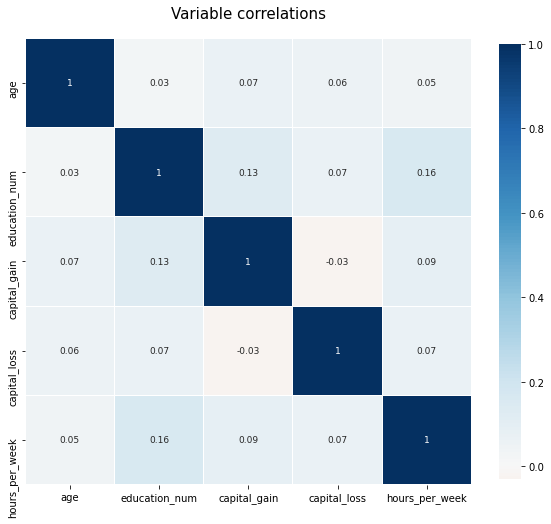

In [20]:
visualize_correlations(reports, data[numerical_cols], '04correlations.jpg')

### visualize all data except for country and education dummies

Let's visualize correlations using one-hot encoded dataset.

There are too many variables for a visual analysis, so we might decide to focus only on the VIF step.

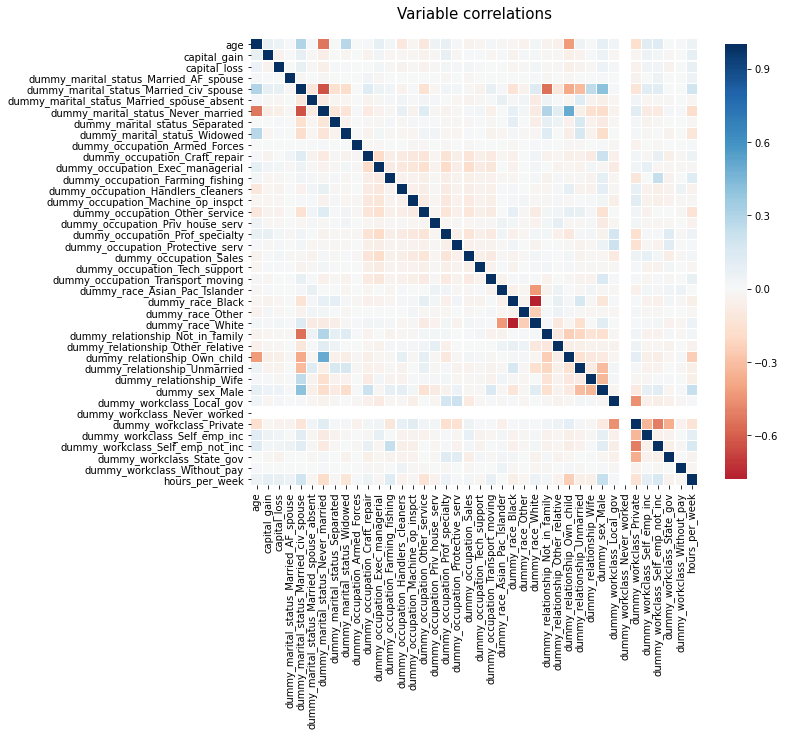

In [21]:
col_selection = [c for c in data.columns.to_list() if 'country' not in c and 'education' not in c]

visualize_correlations(reports, data[col_selection], '04correlations_all.jpg', False)

# Solve multicollinearity

From the perspective of machine learning models, multicolinearity might bring some problems:
* Coefficients become more sensitive to small changes in the model. 
* Reduction on the precision when estimating coefficients.

One way to measure collinearity is through VIF (variance inflation factor), which measures the rise of variance of the estimation of a parameter given the adition of a new variable. To accomplish this, we can use statsmodel, a Python package. More information at:
* https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html

The rule of thumb is to consider the variable collinear when VIF>5. So we are going to use 5 as the threshold for the removal ot variables. An alternative would be to apply PCA on those variables, but on that case, we would lose explainability.

In [22]:
collinear_vars = calculate_vif(data) #X_oh.iloc[:, :]

In [23]:
collinear_vars

['education_num',
 'dummy_native_country_United_States',
 'dummy_race_White',
 'dummy_marital_status_Married_civ_spouse',
 'dummy_workclass_Private',
 'hours_per_week',
 'age',
 'dummy_sex_Male']

In [24]:
X_train_oh_nocol = data.drop(collinear_vars, axis=1)
X_test_oh_nocol = data_test.drop(collinear_vars, axis=1)

# save data with collinearity treatment

In [25]:
file_sufixes = ['X_train_oh_nocol', 'X_test_oh_nocol']

for file_sufix in file_sufixes:
    save_csv(file_sufix)